In [4]:
import math
import pandas as pd
import numpy as np
import random
from scipy.interpolate import UnivariateSpline
from scipy.stats import rankdata
from scipy.special import logit as logit
from matplotlib import pyplot as plt

from cdlib import algorithms, viz
import community as community_louvain
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities,label_propagation_communities, asyn_lpa_communities,greedy_modularity_communities
from networkx.algorithms.centrality import *
from networkx.algorithms.cluster import *
from networkx.algorithms.assortativity import *
# import igraph as ig

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import seaborn as sns
# from Powerset import *

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
id_symbol_lookup_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\Hugo_Symbol_to_id.csv'
# filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\union_genes_4803.csv'

# Gene Network

In [5]:
def const_net(correlation, threshold):
    correlations = np.copy(correlation)
    for i in range(correlations.shape[0]):
        correlations[i][i]=0
    for i in range(correlations.shape[0]):
        for j in range(correlations.shape[0]):
            if correlations[i][j] < threshold and correlations[i][j]>-threshold:
                correlations[i][j]  = 0
            else:
                correlations[i][j]  = 1

    G = nx.Graph()
    G.add_nodes_from(np.arange(correlations.shape[0]))
    edge_list = []
    for i in range(correlations.shape[0]):
         for j in range(i+1, correlations.shape[0]):
                if correlations[i][j] == 1:
                    edge_list.append((i,j))

    print(len(edge_list))
    G.add_edges_from(edge_list)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def plot_degree_dist(G, bins):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees,bins=bins)
    plt.xlabel('node degree',fontsize = 16)
    plt.ylabel('Number of nodes',fontsize = 16)
    plt.show()
    max_deg = bins
    new_degree = []
    for i in range(max_deg):
        a = degrees.count(i)
        new_degree.append(a)
    # print(len(new_degree))



    zp = zip(range(max_deg), new_degree)
    l=list(filter(lambda s:s[1]!=0 ,zp))
    # print(len(l))

    arr = np.array(l)

    l=list(filter(lambda s:s[0]!=0 ,l))
    arr = np.array(l)

    x = arr[:,0].reshape((-1, 1))
    y = arr[:,1]
    x = np.log10(x)

    y = np.log10(y)

    reg = LinearRegression().fit(x, y)
    print(reg.score(x, y), reg.coef_,reg.intercept_)

    cdf = []
    for i in range(len(arr[:,0])):
        a = sum(arr[:,1][i:])
        cdf.append(a)
    # print(cdf)

    plt.xlabel('Degree, k', fontsize=14)
    plt.ylabel('probability, P(x=k)', fontsize=14)
    plt.scatter(arr[:,0], np.divide(arr[:,1],1015))
    plt.yscale('log')#///
    plt.xscale('log')#///
    plt.xlim(0.5, 500)
    plt.ylim(0.0005, 0.5)
    plt.show()

    plt.xlabel('Degree, k', fontsize=14)
    plt.ylabel('CCDF, P(x>=k)', fontsize=14)
    plt.scatter(arr[:,0], np.divide(cdf,1015))
    plt.yscale('log')#///
    plt.xscale('log')#///
    plt.xlim(0.5, 500)
    plt.ylim(0.0005, 1.300)
    plt.show()

### correlation distribution

(9606, 9606)
23068809


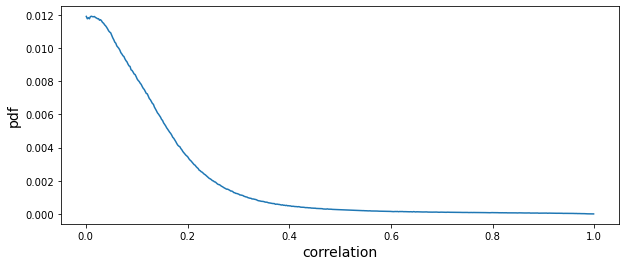

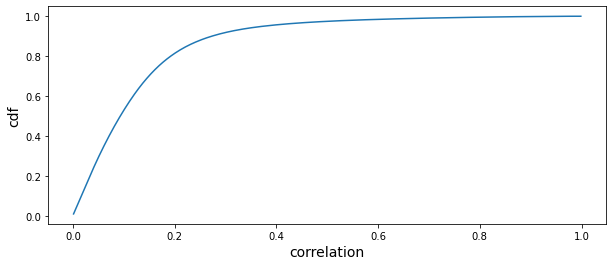

In [8]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]
print(np.corrcoef(df, df).shape)

for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0 :
            correlations[i][j]  = -correlations[i][j]
        
correlations = correlations.flatten()
print(len(correlations))

n = 500
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('pdf', fontsize=14)
plt.plot(x, y)
plt.show()


plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('cdf', fontsize=14)
plt.plot(x, cdfy)
plt.show()

In [23]:
# 1-cdfy[350]

temp_rewards = []

for i in range(5):
    temp_rewards.append(i)
temp_rewards.reverse()
temp_rewards

[4, 3, 2, 1, 0]

In [40]:
rewards = [1.1,2.2,3.3,4.4]
dones = [1,0,3,4]

temp_rewards = []
for reward, done in zip(reversed(rewards), reversed(dones)):
    if done:
        discounted_reward = 0
    discounted_reward = reward
    temp_rewards.insert(0, discounted_reward)
    
print(temp_rewards)
# print()

[1.1, 2.2, 3.3, 4.4]


In [53]:
rewards = [1.1,2.2,3.3,4.4]
dones = [1,0,3,4]
temp_rewards = []
for reward, done in reversed(list(zip(rewards, dones))):
#     if done:
#         discounted_reward = 0
#     print(reward)

    discounted_reward = reward 
    print(discounted_reward)
    temp_rewards.append(discounted_reward)
    print(temp_rewards)
temp_rewards = list(reversed(temp_rewards))
print(temp_rewards)

4.4
[4.4]
3.3
[4.4, 3.3]
2.2
[4.4, 3.3, 2.2]
1.1
[4.4, 3.3, 2.2, 1.1]
[1.1, 2.2, 3.3, 4.4]


In [48]:
rewards = [1.1,2.2,3.3,4.4]
# dones = [1,0,3,4]

temp_rewards = []
for i in range(6):
    temp_rewards.append(i)
list(reversed(temp_rewards))

[5, 4, 3, 2, 1, 0]

### Net construct. Base on correaltion CDF. Set link threshold to 0.65 (avg node degree = 19.7) or 0.7 (avg node degree = 11.6)

0.65
139694
3136


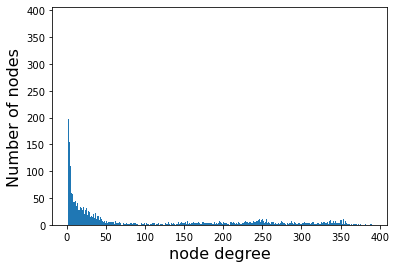

In [ ]:
df = pd.read_csv(filterd_data).drop(columns = ['ID'])
correlations = np.corrcoef(df, df)[:4803, :4803]

coms = []



for thre in np.arange(0.65, 0.71, 0.05):
    print(thre)
    G = const_net(correlations, thre)
    print(G.number_of_nodes())
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    plot_degree_dist(G, dmax)
    com = algorithms.demon(G, min_com_size=40, epsilon=0.25) # works
#     com = algorithms.node_perception(G, threshold=0.25, overlap_threshold=0.25)
    coms.append(com)


In [48]:
for com in coms:
    clusters = com.to_node_community_map()
    conmmunities = []
    for i in range(100):
        conmmunities.append([])


    for i in clusters.keys():
        c = clusters[i]
        for j in c:
#             print(j)
            conmmunities[j].append(i)
    conmmunities = [ item for item in conmmunities if item != [] ]
    com_size = len(conmmunities)
    
    clusters = com.to_node_community_map() 

    com_intersect_mat = np.zeros((com_size,com_size))
    for a in range(com_size):
        for b in range(com_size):
            intersect_com = set([a,b])

            for each in clusters:
                if intersect_com .issubset(set(clusters[each])):
                    com_intersect_mat[a,b]+=1
    print('Community overlapping table')
    print(pd.DataFrame(com_intersect_mat))

Community overlapping table
       0      1      2      3     4     5
0  746.0  699.0    4.0    0.0   0.0   0.0
1  699.0  741.0    5.0    0.0   0.0   0.0
2    4.0    5.0  198.0    0.0   0.0   3.0
3    0.0    0.0    0.0  157.0   0.0   0.0
4    0.0    0.0    0.0    0.0  94.0   0.0
5    0.0    0.0    3.0    0.0   0.0  58.0
Community overlapping table
       0      1      2     3     4     5
0  524.0  473.0    0.0   0.0   0.0   0.0
1  473.0  511.0    0.0   0.0   0.0   0.0
2    0.0    0.0  106.0   0.0   0.0   0.0
3    0.0    0.0    0.0  92.0   0.0   0.0
4    0.0    0.0    0.0   0.0  78.0   0.0
5    0.0    0.0    0.0   0.0   0.0  48.0


### Gene net threshold selection and community detection

# Decision Tree model

### prepare data

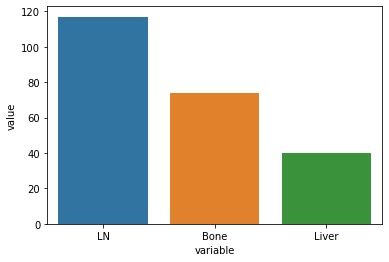

In [239]:
# with data balance
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

features_df = pd.read_csv(network_features)

def get_class_distribution(obj):
        count_dict = {
            "LN": 0,
            "Bone": 0,
            "Liver": 0
        } 
        for i in obj:
            if i == 0: 
                count_dict['LN'] += 1
            elif i == 1: 
                count_dict['Bone'] += 1
            elif i == 2: 
                count_dict['Liver'] += 1          
            else:
                print("Check classes.")          
        return count_dict
    
def data_preparation(filterd_data_path, data_balance=False):
    genes_df = pd.read_csv(filterd_data_path)
    df = genes_df.drop(columns = ['ID'])
    

    if data_balance:
        pt_np = np.array(df.T)
        ln_np = np.array_split(np.repeat(shuffle(pt_np[:117]),2, axis=0) ,10)
        bo_np = np.array_split(np.repeat(shuffle(pt_np[117:191]),3, axis=0),10)
        li_np = np.array_split(np.repeat(shuffle(pt_np[191:]),6, axis=0),10)

        xs = []
        ys = []
        for i in range(10):
            tp_x = np.concatenate((ln_np[i],bo_np[i], li_np[i]))
            tp_y = [0] * len(ln_np[i]) + [1] * len(bo_np[i]) + [2] * len(li_np[i])
            tp_x,tp_y = shuffle(tp_x,tp_y)
            xs+=list(tp_x)
            ys+=tp_y

        xs = np.array(xs)
        ys = np.array(ys)
        df = pd.DataFrame(xs)
        cancer_types = ys

    else:   
        cancer_types =  [0]*117+[1]*74+[2]*40
        df = df.T
    df['cancer'] = cancer_types
    #     print(df)

    class2idx = {
        0:0,
        1:1,
        2:2}
    idx2class = {v: k for k, v in class2idx.items()}
    df['cancer'].replace(class2idx, inplace=True)
    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1]
    if not data_balance:
        X, y = shuffle(X, y, random_state=0)
    return X,y

X,y = data_preparation(filterd_data)
ori_X = X.copy(deep=True)
ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y)]).melt(),\
                x = "variable", y="value")

[2, 9, 115, 123, 151, 177, 199, 236, 241, 242, 245, 310, 414, 502, 555, 728, 743, 940, 945, 1031, 1035, 1052, 1085, 1089, 1122, 1125, 1196, 1218, 1328, 1440, 1500, 1594, 1597, 1655, 1814, 1840, 1902, 1920, 1946, 2130, 2136, 2162, 2193, 2206, 2294, 2457, 2617, 2912, 3121, 3266, 3347, 3419, 3483, 3618, 3705, 3738, 3940, 4036, 4062, 4234, 4359, 4377, 4932, 5193, 5415, 5551, 5637, 5742, 6100, 6271, 6309, 6416, 6505, 6577, 6599, 6782, 6823, 7000, 7241, 7396, 7454, 7531, 7532, 7850, 7863, 7950, 8005, 8075, 8405, 8718, 8783, 8842, 8916, 8959, 8988, 9152, 9165, 9166, 9184, 9188, 9386, 9414, 9621, 9650, 9748, 10258, 10430, 10522, 10557, 10677, 10819, 10824, 10949, 10977, 11022, 11290, 11716, 11724, 12102, 12218, 12331, 12343, 12599, 12628, 12698, 12898, 12916, 13014, 13580, 13683, 13749, 13940, 14119]
32     PPP1R16A
48        CXXC1
11       MAGED2
36          PTS
99       TMSB4Y
         ...   
98         CCR7
100      B3GLCT
101      ZBTB25
102      GPR162
41         PLS3
Name: Hugo_Symbol, L

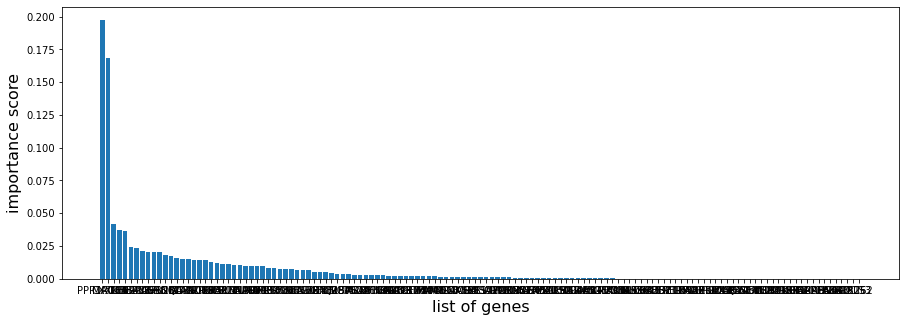

In [240]:
genes_df = pd.read_csv(filterd_data)

model = XGBClassifier()
model.fit(X, y)
# get importance
importance = model.feature_importances_


# trace_list = list(range(len(importance)))
# genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
# # print(genes_df)
# genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
# sorted_index_by_importance = list(genes_df['index'])
# sorted_index_by_importance

id_symbol_lookup_df = pd.read_csv(id_symbol_lookup_file)
top_genes = []
top_gene_importance = []
for i in range(len(genes_df)):
    top_genes.append(genes_df['ID'][i])
    top_gene_importance.append(importance[i])

print(top_genes)
# id_symbol_lookup_df
# print(list(id_symbol_lookup_df['ID']))
# print(list(id_symbol_lookup_df['Hugo_Symbol']))
ids = list(id_symbol_lookup_df['ID'])
symbols = list(id_symbol_lookup_df['Hugo_Symbol'])
top_genes_symbol = []
for i in top_genes:
    top_genes_symbol.append(symbols[i])

top_genes_df = pd.DataFrame({'Hugo_Symbol':top_genes_symbol,'importance':top_gene_importance}) 

top_genes_df = top_genes_df.sort_values(by='importance',axis=0,ascending=[False])

print(top_genes_df['Hugo_Symbol'])

# print(top_gene_importance)
plt.figure(figsize=(15,5))
plt.bar(top_genes_df['Hugo_Symbol'], top_genes_df['importance'])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)


In [226]:
top_genes_df

,Hugo_Symbol,importance
32,PPP1R16A,0.197455
48,CXXC1,0.168804
11,MAGED2,0.042007
36,PTS,0.037378
99,TMSB4Y,0.036455
...,...,...
98,CCR7,0.000000
100,B3GLCT,0.000000
101,ZBTB25,0.000000
102,GPR162,0.000000


In [235]:
list(X.columns)

[0,
 2,
 4,
 7,
 11,
 12,
 16,
 21,
 22,
 28,
 31,
 32,
 33,
 36,
 48,
 57,
 61,
 64,
 66,
 68,
 69,
 70,
 71,
 80,
 83,
 85,
 93,
 96,
 99,
 107,
 118,
 120,
 123,
 129]

13
[115, 236, 310, 1052, 1085, 1328, 1597, 1902, 3121, 5415, 5637, 6271, 12331]
6     PPP1R16A
8        CXXC1
2       MAGED2
12      LRRC66
1       ERGIC3
4         GARS
0        RPL23
9     RAP1GAP2
10        IQCE
5       UBE2L3
3        UBE2Z
11      CARD16
7          PTS
Name: Hugo_Symbol, dtype: object


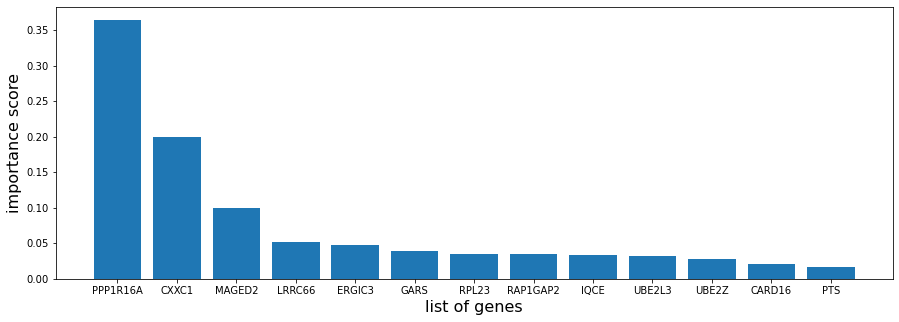

In [242]:
gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]
len(gene_taken_off_sequence)
features_df = pd.read_csv(network_features)
# print(accs[-11])
drop_index = gene_taken_off_sequence[:-10]
# tp = gene_taken_off_sequence[-31:]
X,y = data_preparation(filterd_data,True)
X = X.drop(columns=drop_index)


model = XGBClassifier()
model.fit(X, y)
# get importance
importance = model.feature_importances_


# trace_list = list(range(len(importance)))
# genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
# # print(genes_df)
# genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
# sorted_index_by_importance = list(genes_df['index'])
# sorted_index_by_importance

id_symbol_lookup_df = pd.read_csv(id_symbol_lookup_file)
top_genes = []
top_gene_importance = []
print(len(importance))
for i in range(len(importance)):
    top_genes.append(genes_df['ID'][list(X.columns)[i]])
    top_gene_importance.append(importance[i])

print(top_genes)
# id_symbol_lookup_df
# print(list(id_symbol_lookup_df['ID']))
# print(list(id_symbol_lookup_df['Hugo_Symbol']))
ids = list(id_symbol_lookup_df['ID'])
symbols = list(id_symbol_lookup_df['Hugo_Symbol'])
top_genes_symbol = []
for i in top_genes:
    top_genes_symbol.append(symbols[i])

top_genes_df = pd.DataFrame({'Hugo_Symbol':top_genes_symbol,'importance':top_gene_importance}) 

top_genes_df = top_genes_df.sort_values(by='importance',axis=0,ascending=[False])

print(top_genes_df['Hugo_Symbol'])
# print(top_gene_importance)
plt.figure(figsize=(15,5))
plt.bar(top_genes_df['Hugo_Symbol'], top_genes_df['importance'])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)

top_genes_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\top13.csv")

### X_Val and tail gene removal 

In [163]:
def drop_last_importance_gene(current_gene_X, drop_index):
    res_X = current_gene_X.drop(columns=[drop_index])
    return res_X

lp_acc = []
for lp in range(10):
    
    print("Loop "+str(lp))
    accs = []
    gene_taken_off_sequence = []
    
    X,y = data_preparation(filterd_data,True)
    
    model = XGBClassifier()
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    trace_list = list(range(len(importance)))
    genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
    # print(genes_df)
    genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
    sorted_index_by_importance = list(genes_df['index'])

    for i in range(130):
        last_important_gene_id = sorted_index_by_importance.pop(-1)
        gene_taken_off_sequence.append(last_important_gene_id)
        trace_list.remove(last_important_gene_id)
#         print(last_important_gene_id)
        X = drop_last_importance_gene(X, last_important_gene_id)
#         print(X.shape[1])
        model = XGBClassifier()
        kfold = KFold(n_splits=10)
        results = cross_val_score(model, X, y, cv=kfold) # same data split for each loop
        print("Accuracy: %.2f%%" % (results.mean()*100))
        accs.append(results.mean())
        model = XGBClassifier()
        model.fit(X, y)
        # get importance
        importance = model.feature_importances_
        genes_df = pd.DataFrame({'index':trace_list,'importance':importance}) 
        genes_df = genes_df.sort_values(by='importance',axis=0,ascending=[False])
        sorted_index_by_importance = list(genes_df['index'])
    lp_acc.append(accs)

Loop 0
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.07%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.36%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accurac

Accuracy: 92.53%
Accuracy: 93.40%
Accuracy: 93.40%
Accuracy: 93.40%
Accuracy: 93.84%
Accuracy: 93.84%
Accuracy: 93.84%
Accuracy: 93.84%
Accuracy: 93.84%
Accuracy: 92.68%
Accuracy: 91.82%
Accuracy: 92.68%
Accuracy: 92.68%
Accuracy: 92.68%
Accuracy: 91.82%
Accuracy: 92.11%
Accuracy: 92.11%
Accuracy: 91.82%
Accuracy: 91.82%
Accuracy: 92.68%
Accuracy: 91.82%
Accuracy: 91.82%
Accuracy: 91.54%
Accuracy: 92.70%
Accuracy: 92.40%
Accuracy: 93.27%
Accuracy: 93.27%
Accuracy: 92.98%
Accuracy: 92.69%
Accuracy: 93.13%
Accuracy: 91.97%
Accuracy: 91.40%
Accuracy: 90.67%
Accuracy: 90.39%
Accuracy: 91.54%
Accuracy: 89.66%
Accuracy: 91.26%
Accuracy: 83.35%
Accuracy: 82.07%
Loop 4
Accuracy: 90.68%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.96%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.82%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.54%
Accuracy: 91.39%
Accuracy: 91.39%
Accurac

Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.06%
Accuracy: 91.06%
Accuracy: 91.50%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.07%
Accuracy: 91.93%
Accuracy: 91.64%
Accuracy: 91.64%
Accuracy: 91.64%
Accuracy: 91.64%
Accuracy: 90.78%
Accuracy: 91.07%
Accuracy: 91.50%
Accuracy: 92.07%
Accuracy: 91.78%
Accuracy: 90.93%
Accuracy: 90.93%
Accuracy: 90.93%
Accuracy: 91.21%
Accuracy: 90.93%
Accuracy: 90.93%
Accuracy: 90.93%
Accuracy: 91.21%
Accuracy: 90.92%
Accuracy: 91.2

[0.90425466 0.9065528  0.90598137 0.90598137 0.90640994 0.90598137
 0.90598137 0.90569565 0.90569565 0.9065528  0.90683851 0.90596894
 0.90582609 0.9055528  0.90526708 0.9065528  0.90613043 0.90684472
 0.90640994 0.90540994 0.90569565 0.9054058  0.9054058  0.9054058
 0.90569565 0.90439752 0.90439752 0.90395652 0.90395652 0.90481366
 0.90524224 0.90610766 0.9049648  0.90554037 0.90611594 0.90611594
 0.90596894 0.90683851 0.9065528  0.90713872 0.90800828 0.90786957
 0.90685093 0.90712836 0.90726708 0.90755694 0.90971636 0.90928778
 0.90900207 0.90756108 0.90843685 0.90886542 0.90801449 0.90887164
 0.90916149 0.90915735 0.90727743 0.90813458 0.91015321 0.90944306
 0.9095735  0.91015735 0.90915735 0.91031263 0.91031263 0.91031263
 0.91031263 0.91030849 0.90885093 0.91203106 0.91260663 0.91203106
 0.91218219 0.91260663 0.91202692 0.9117412  0.91346791 0.91146377
 0.91305176 0.91131263 0.91230642 0.91188406 0.90743064 0.91174534
 0.91102692 0.91318841 0.91404555 0.9173499  0.91477226 0.91705

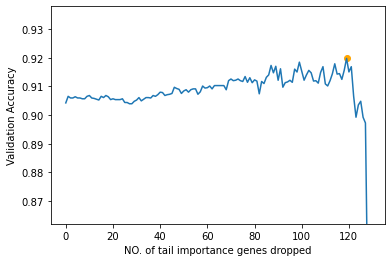

In [201]:
accs = np.mean(lp_acc,axis=0)
print(accs)
print(gene_taken_off_sequence)

plt.figure()
plt.xlabel('NO. of tail importance genes dropped')
plt.ylabel('Validation Accuracy')
plt.plot(np.arange(len(accs)), accs)
plt.scatter(119, accs[119], color = 'orange')
plt.ylim([0.862, 0.938])
# plt.scatter(112, accs[112], color = 'y')
plt.show()
# drop_index = gene_taken_off_sequence[:-26] for good prediction. 
# drop_index = gene_taken_off_sequence[:-8] for testing patient net features

In [ ]:
# result for original dataset
"""
[0.92288043 0.9190942  0.9198913  0.92201087 0.92610507 0.92197464
 0.9211413  0.92076087 0.92052536 0.92072464 0.91820652 0.91896739
 0.91820652 0.92342391 0.92469203 0.92123188 0.92516304 0.91572464
 0.92367754 0.91824275 0.92266304 0.92030797 0.92121377 0.91476449
 0.92255435 0.92132246 0.9207971  0.91911232 0.92038043 0.92206522
 0.92043478 0.92240942 0.92166667 0.92641304 0.92630435 0.92378623
 0.91733696 0.91849638 0.92072464 0.92155797 0.92333333 0.9246558
 0.9245471  0.9195471  0.92414855 0.92376812 0.9242029  0.91905797
 0.92335145 0.92380435 0.91731884 0.91817029 0.92126812 0.92423913
 0.92467391 0.9226087  0.92461957 0.91853261 0.92206522 0.92643116
 0.92336957 0.92431159 0.92507246 0.92603261 0.9225     0.92686594
 0.92557971 0.93202899 0.92336957 0.92615942 0.92422101 0.92592391
 0.92601449 0.92688406 0.92559783 0.92478261 0.92460145 0.92807971
 0.92425725 0.92594203 0.92681159 0.93554348 0.9313587  0.93458333
 0.93117754 0.93331522 0.93237319 0.93289855 0.92907609 0.93588768
 0.93201087 0.92990942 0.93173913 0.92938406 0.9328442  0.93201087
 0.93416667 0.93467391 0.93152174 0.93853261 0.93164855 0.93467391
 0.93244565 0.92938406 0.93038043 0.92369565 0.91826087 0.91822464
 0.9176087  0.91943841 0.91552536 0.92382246 0.91822464 0.92300725
 0.91505435 0.91688406 0.91507246 0.92175725 0.91947464 0.92768116
 
 0.92333333 0.92221014 0.91389493 0.90777174 0.90527174 0.89990942
 0.90862319 0.90905797 0.89574275 0.86153986]
 
[41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 
102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 
127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 
72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 
30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 
31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 

64, 69, 7, 28, 2, 66, 36, 120, 21, 22]


"""

In [173]:
# # accs = [0.90425466, 0.9065528 , 0.90598137, 0.90598137, 0.90640994,
#        0.90598137, 0.90598137, 0.90569565, 0.90569565, 0.9065528 ,
#        0.90683851, 0.90596894, 0.90582609, 0.9055528 , 0.90526708,
#        0.9065528 , 0.90613043, 0.90684472, 0.90640994, 0.90540994,
#        0.90569565, 0.9054058 , 0.9054058 , 0.9054058 , 0.90569565,
#        0.90439752, 0.90439752, 0.90395652, 0.90395652, 0.90481366,
#        0.90524224, 0.90610766, 0.9049648 , 0.90554037, 0.90611594,
#        0.90611594, 0.90596894, 0.90683851, 0.9065528 , 0.90713872,
#        0.90800828, 0.90786957, 0.90685093, 0.90712836, 0.90726708,
#        0.90755694, 0.90971636, 0.90928778, 0.90900207, 0.90756108,
#        0.90843685, 0.90886542, 0.90801449, 0.90887164, 0.90916149,
#        0.90915735, 0.90727743, 0.90813458, 0.91015321, 0.90944306,
#        0.9095735 , 0.91015735, 0.90915735, 0.91031263, 0.91031263,
#        0.91031263, 0.91031263, 0.91030849, 0.90885093, 0.91203106,
#        0.91260663, 0.91203106, 0.91218219, 0.91260663, 0.91202692,
#        0.9117412 , 0.91346791, 0.91146377, 0.91305176, 0.91131263,
#        0.91230642, 0.91188406, 0.90743064, 0.91174534, 0.91102692,
#        0.91318841, 0.91404555, 0.9173499 , 0.91477226, 0.91705797,
#        0.91216977, 0.91618427, 0.90974327, 0.91132712, 0.9115942 ,
#        0.9121677 , 0.9114472 , 0.9160559 , 0.9150559 , 0.91849896,
#        0.91533954, 0.91218841, 0.91403727, 0.91562526, 0.91476812,
#        0.91189441, 0.91201656, 0.91115942, 0.91490476, 0.91691925,
#        0.91089027, 0.91018012, 0.91202692, 0.91447205, 0.91792961,
#        0.91432505, 0.91449482, 0.91248033, 0.91563354, 0.91979917,
#        0.91508489, 0.91691511, 0.9065942 , 0.89925259, 0.90354451,
#        0.90483437, 0.89924017, 0.89724431, 0.83425466, 0.82218427]
# accs

0.91979917184265
Accuracy: 92.17% (6.09%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
Accuracy: 92.21% (4.25%)
0.8298913043478262
       0     1     2
0  111.8   3.1   2.1
1    7.8  66.2   0.0
2    4.9   0.0  35.1
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1170
           1       0.96      0.89      0.92       740
           2       0.94      0.88      0.91       400

    accuracy                           0.92      2310
   macro avg       0.93      0.91      0.92      2310
weighted avg       0.92      0.92      0.92      2310



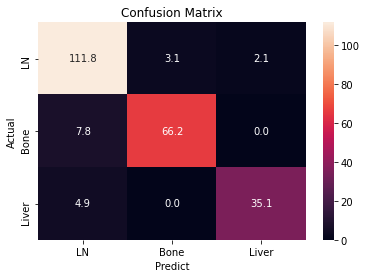

In [175]:

gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]
len(gene_taken_off_sequence)
features_df = pd.read_csv(network_features)
print(accs[-11])
drop_index = gene_taken_off_sequence[:-10]

X,y = data_preparation(filterd_data)
X = X.drop(columns=drop_index)


model = XGBClassifier()
# kfold = KFold(n_splits=10,shuffle=True)

kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
y_pred = list(cross_val_predict(model, X, y, cv=kfold))
conf_mat = confusion_matrix(y, y_pred)
# print(conf_mat)
acc = 0
for i in range(9):
    X,y = data_preparation(filterd_data)
    X = X.drop(columns=drop_index)
    model = XGBClassifier()
    # kfold = KFold(n_splits=10,shuffle=True)

    kfold = KFold(n_splits=10)
    results = cross_val_score(model, X, y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    acc += results.mean()
    y_pred += list(cross_val_predict(model, X, y, cv=kfold))
#     y_pred+=y_pred
#     print(conf_mat)

y = list(y)*10
conf_mat = confusion_matrix(y, y_pred)/10
print(acc/10)
class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)
print(pd.DataFrame(conf_mat))
confusion_matrix_df = pd.DataFrame(conf_mat).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True, fmt=".1f").set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(y, y_pred))

In [83]:
len(y_pred)

462

# Patient network

### Patient network construction: 
Based on results above, only keep the most 29 important genes.

In [203]:
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
network_features = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv'

gene_taken_off_sequence = [41, 88, 95, 34, 81, 82, 65, 62, 100, 104, 115, 29, 113, 91, 37, 56, 116, 17, 18, 60, 102, 78, 122, 121, 73, 105, 50, 98, 45, 119, 92, 84, 14, 15, 130, 101, 128, 126, 125, 127, 51, 103, 124, 26, 59, 42, 77, 8, 6, 35, 111, 90, 19, 38, 97, 58, 112, 23, 55, 47, 72, 114, 89, 54, 106, 1, 117, 20, 25, 131, 9, 3, 108, 79, 43, 110, 86, 39, 5, 24, 52, 30, 109, 53, 10, 87, 27, 132, 67, 44, 94, 75, 49, 13, 76, 74, 40, 46, 63, 68, 123, 12, 31, 33, 71, 118, 93, 4, 80, 96, 83, 85, 129, 0, 16, 107, 99, 61, 70, 57, 64, 69, 7, 28, 2, 66, 36, 120, 21, 22]
len(gene_taken_off_sequence)
features_df = pd.read_csv(network_features)
# print(accs[-32])
drop_index = gene_taken_off_sequence[:-10]

X = ori_X.drop(columns=drop_index)

df = X
df


,11,32,48
0,0.906,0.054,0.017
1,0.289,0.035,0.040
2,0.050,0.009,0.008
3,0.065,0.050,0.008
4,2.394,0.556,0.019
...,...,...,...
691,0.080,0.000,0.013
692,0.118,0.000,0.008
693,346.363,10.715,0.000
694,0.155,0.119,0.084


133

### Patient network link(correlation) distribution

[[0.99479223 0.98356299 0.98853044 ... 0.06240155 0.99618089 0.06240155]
 [0.99479223 0.98831958 0.9979808  ... 0.03368897 0.98999232 0.03368897]
 [0.98356299 0.98831958 0.98330314 ... 0.03212018 0.98765245 0.03212018]
 ...
 [0.06240155 0.03368897 0.03212018 ... 0.14074769 0.08180619 1.        ]
 [0.99618089 0.98999232 0.98765245 ... 0.12446157 0.08180619 0.08180619]
 [0.06240155 0.03368897 0.03212018 ... 0.14074769 1.         0.08180619]]
53130


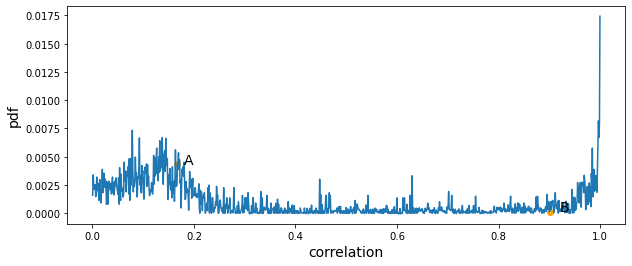

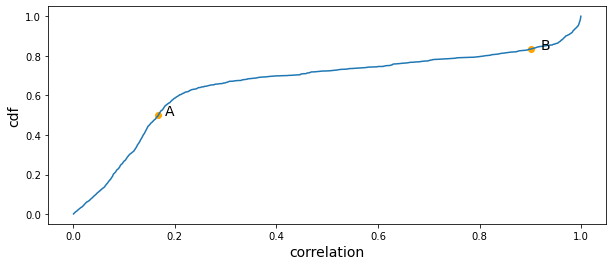

correlation threshold to median:  0.16766520008112704 CDF 0.500281103311835
correlation threshold to 0.99:  0.9005197446343209 CDF 0.8339462693448858


In [191]:
X = ori_X.drop(columns=drop_index)

correlations = np.corrcoef(X, X)[:231, :231]

for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 

correlations = correlations[~np.eye(correlations.shape[0],dtype=bool)].reshape(correlations.shape[0],-1)# remove diagnal
print(correlations)
correlations = correlations.flatten()
print(len(correlations))


n = 1000
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('pdf', fontsize=14)
plt.plot(x, y)
plt.scatter(x[167], y[167], color = 'orange')
plt.scatter(x[900], y[900], color = 'orange')
plt.text(0.18, y[167], 'A', fontsize=14)
plt.text(0.92, y[900], 'B', fontsize=14)
plt.show()


plt.figure(figsize=(10,4))
plt.xlabel('correlation', fontsize=14)
plt.ylabel('cdf', fontsize=14)
plt.plot(x, cdfy)
plt.scatter(x[167], cdfy[167], color = 'orange')
plt.scatter(x[900], cdfy[900], color = 'orange')
plt.text(0.18, cdfy[167], 'A', fontsize=14)
plt.text(0.92, cdfy[900], 'B', fontsize=14)
plt.show()

print('correlation threshold to median: ',x[167], 'CDF', cdfy[167])
print('correlation threshold to 0.99: ',x[900], 'CDF', cdfy[900])

correlation threshold to median:  0.16766520008112704 CDF 0.500281103311835
correlation threshold to 0.99:  0.9005197446343209 CDF 0.8339462693448858


In [32]:
a = 821
print(x[a], cdfy[a]) #0.8215008462598562 0.4994515835445561

0.8215008462598562 0.4994515835445561


### Weighted Patient Net construction. 


In [192]:
df = X

correlations = np.corrcoef(df, df)[:231, :231]
for i in range(correlations.shape[0]):
    correlations[i][i]=0
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[0]):
        if correlations[i][j] < 0:
            correlations[i][j]  = -correlations[i][j] 
            
ex_df = pd.DataFrame(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))

for i in range(correlations.shape[0]):
    for j in range(i+1,correlations.shape[0]):
        G.add_edge(i, j, weight=correlations[i][j])
#         print(correlations[i][j])



patient_net_features_df = pd.DataFrame()
de = G.degree(weight='weight')
cc = nx.clustering(G,weight='weight')

patient_net_features_df['weighted_degree'] = np.array(de).T[1][:]
patient_net_features_df['weighted_clustering_coef'] = cc.values()
patient_net_features_df

# # Community detection on weighted network
# # com = algorithms.louvain(G,weight='weight')
# com = algorithms.greedy_modularity(G,weight='weight')
# # com = algorithms.agdl(G,number_communities=3, kc=4)
# com.to_node_community_map()

# clusters = com.to_node_community_map()

# com_list = np.array(list(clusters.values())).flatten()
# com_num = max(com_list)+1
# node_list = list(clusters.keys())
# print(com_num)
# LN_p = [0]*com_num
# Bone_p = [0]*com_num
# Liver_p = [0]*com_num

# for i in range(len(com_list)):
#     node_No = node_list[i]
#     com_NO = com_list[i]
# #     print(com_NO)
#     if node_No <117:
#         LN_p[com_NO]+=1
#     elif node_No >= 117 and node_No <191:
#         Bone_p[com_NO]+=1
#     else:
#         Liver_p[com_NO]+=1
        
# print(sum(LN_p),sum(Bone_p),sum(Liver_p))
# patient_com_df = pd.DataFrame()
# patient_com_df['LN'] = LN_p
# patient_com_df['Bone'] = Bone_p
# patient_com_df['Liver'] = Liver_p
# patient_com_df

,weighted_degree,weighted_clustering_coef
0,94.296966,0.274205
1,92.064607,0.263983
2,91.087215,0.256094
3,93.302221,0.279074
4,38.182135,0.157407
...,...,...
226,77.780293,0.255126
227,78.548260,0.255737
228,73.403918,0.229069
229,95.902399,0.281653


In [124]:
# com.newman_girvan_modularity() #louvain 4 coms score=0.03997515260593122. greedy_modularity
# com.z_modularity() #louvain score=-0.005028898200744024. greedy_modularity

### Convert to unweighted graph. 
Base on above observation, set threshold to 0.99.

In [ ]:
# # For gephi
# cores = np.copy(correlations)
# print(correlations)
# link_thres = 0.99

# link_num = 0
# for i in range(cores.shape[0]):
#     for j in range(cores.shape[1]):
#         if cores[i,j] > link_thres:
#             cores[i,j] = 1
#             link_num+=1
#         else:
#             cores[i,j] = 0
# print("Number of links: ", link_num)
# print("Avg. Node Degree: ", link_num/231)

# temp_df = pd.DataFrame(cores)
# temp_df
# # temp_df.to_csv("C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\patient_net_features.csv")

In [34]:
np.median(correlations)

0.8212544234879704

Number of links:  13221
Avg. Node Degree:  114.46753246753246
     weighted_degree  weighted_clustering_coef  degree_82  clustering_coef_82  \
0          94.296966                  0.274205        145            0.808429   
1          92.064607                  0.263983        111            0.905979   
2          91.087215                  0.256094        129            0.801478   
3          93.302221                  0.279074        102            0.928169   
4          38.182135                  0.157407         24            1.000000   
..               ...                       ...        ...                 ...   
226        77.780293                  0.255126         72            1.000000   
227        78.548260                  0.255737         75            0.971892   
228        73.403918                  0.229069        122            0.908413   
229        95.902399                  0.281653        151            0.763532   
230        73.403918                  0.229069 

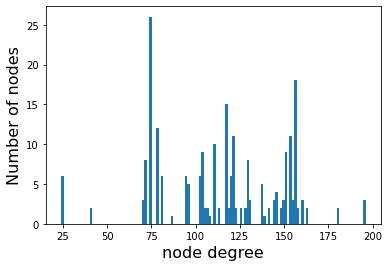

In [193]:
X = ori_X.drop(columns=drop_index)

correlations = np.corrcoef(X, X)[:231, :231]

# link_thres = 0.90
link_thres = np.median(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
link_num = 0
for i in range(correlations.shape[0]):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > link_thres:
            G.add_edge(i, j)
            link_num+=1
print("Number of links: ", link_num)
print("Avg. Node Degree: ", link_num*2/231)

de = G.degree()
cc = nx.clustering(G)
patient_net_features_df['degree_82'] = np.array(de).T[1][:]
patient_net_features_df['clustering_coef_82'] = cc.values()
patient_net_features_df['average_neighbor_degree_82'] = average_neighbor_degree(G).values()
# Add code to calculate Avg. Neighbour degree
average_neighbor_degree(G)
# End of code

patient_net_features_df.round(3)
print(patient_net_features_df)


plot_degree_dist(G,128)

Number of links:  4415
Avg. Node Degree:  38.22510822510822
     weighted_degree  weighted_clustering_coef  degree_82  clustering_coef_82  \
0          94.296966                  0.274205        145            0.808429   
1          92.064607                  0.263983        111            0.905979   
2          91.087215                  0.256094        129            0.801478   
3          93.302221                  0.279074        102            0.928169   
4          38.182135                  0.157407         24            1.000000   
..               ...                       ...        ...                 ...   
226        77.780293                  0.255126         72            1.000000   
227        78.548260                  0.255737         75            0.971892   
228        73.403918                  0.229069        122            0.908413   
229        95.902399                  0.281653        151            0.763532   
230        73.403918                  0.229069   

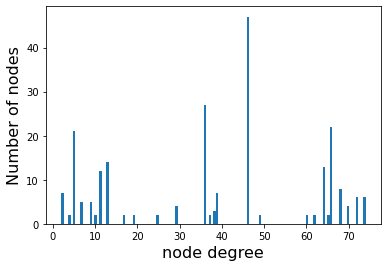

In [194]:
X = ori_X.drop(columns=drop_index)

correlations = np.corrcoef(X, X)[:231, :231]

link_thres = 0.90
# link_thres = np.median(correlations)

G = nx.Graph()
G.add_nodes_from(np.arange(231))
# G.nodes()
link_num = 0
for i in range(correlations.shape[0]):
    for j in range(i+1,correlations.shape[0]):
        if correlations[i,j] > link_thres:
            G.add_edge(i, j)
            link_num+=1
print("Number of links: ", link_num)
print("Avg. Node Degree: ", link_num*2/231)

de = G.degree()
cc = nx.clustering(G)
patient_net_features_df['degree_99'] = np.array(de).T[1][:]
patient_net_features_df['clustering_coef_99'] = cc.values()
patient_net_features_df['average_neighbor_degree_99'] = average_neighbor_degree(G).values()
# Add code to calculate Avg. Neighbour degree
average_neighbor_degree(G)
# End of code

patient_net_features_df.round(3)
print(patient_net_features_df)


plot_degree_dist(G,128)

In [195]:
X = ori_X.drop(columns=drop_index)



(231, 21)
Accuracy: 92.17% (5.07%)
Accuracy: 92.23% (3.72%)
Accuracy: 92.19% (4.28%)
Accuracy: 92.68% (5.39%)
Accuracy: 93.08% (3.97%)
Accuracy: 93.50% (2.93%)
Accuracy: 93.51% (3.48%)
Accuracy: 91.78% (4.54%)
Accuracy: 93.10% (2.77%)
Accuracy: 92.63% (5.17%)
0.9268659420289858
       0     1     2
0  112.7   3.8   0.5
1    7.3  66.6   0.1
2    4.2   0.4  35.4
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1170
           1       0.94      0.90      0.92       740
           2       0.98      0.89      0.93       400

    accuracy                           0.93      2310
   macro avg       0.94      0.92      0.93      2310
weighted avg       0.93      0.93      0.93      2310



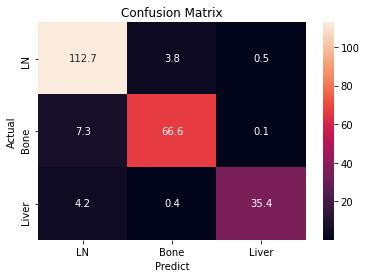

In [196]:

X,y = data_preparation(filterd_data)
X = X.drop(columns=drop_index)

X['weighted_degree'] = list(patient_net_features_df['weighted_degree'])
X['weighted_clustering_coef'] = list(patient_net_features_df['weighted_clustering_coef'])
X['degree_99'] = list(patient_net_features_df['degree_99'])
X['clustering_coef_99'] = list(patient_net_features_df['clustering_coef_99'])
X['average_neighbor_degree_99'] = list(patient_net_features_df['average_neighbor_degree_99'])
X['degree_82'] = list(patient_net_features_df['degree_82'])
X['clustering_coef_82'] = list(patient_net_features_df['clustering_coef_82'])
X['average_neighbor_degree_82'] = list(patient_net_features_df['average_neighbor_degree_82'])
model = XGBClassifier()
# kfold = KFold(n_splits=10,shuffle=True)
print(X.shape)
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(model, X, y, cv=kfold)
acc = results.mean()
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
y_pred = list(cross_val_predict(model, X, y, cv=kfold))
conf_mat = confusion_matrix(y, y_pred)
# print(conf_mat)

for i in range(9):
    
    X,y = data_preparation(filterd_data)
    X = X.drop(columns=drop_index)

    X['weighted_degree'] = list(patient_net_features_df['weighted_degree'])
    X['weighted_clustering_coef'] = list(patient_net_features_df['weighted_clustering_coef'])
    X['degree_99'] = list(patient_net_features_df['degree_99'])
    X['clustering_coef_99'] = list(patient_net_features_df['clustering_coef_99'])
    X['average_neighbor_degree_99'] = list(patient_net_features_df['average_neighbor_degree_99'])
    X['degree_82'] = list(patient_net_features_df['degree_82'])
    X['clustering_coef_82'] = list(patient_net_features_df['clustering_coef_82'])
    X['average_neighbor_degree_82'] = list(patient_net_features_df['average_neighbor_degree_82'])
    model = XGBClassifier()
    # kfold = KFold(n_splits=10,shuffle=True)

    kfold = KFold(n_splits=10,shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold)
    acc += results.mean()
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    y_pred += list(cross_val_predict(model, X, y, cv=kfold))
#     y_pred+=y_pred
#     print(conf_mat)
print(acc/10)
ty = list(y)*10
conf_mat = confusion_matrix(ty, y_pred)/10

class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)
print(pd.DataFrame(conf_mat))
confusion_matrix_df = pd.DataFrame(conf_mat).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True, fmt=".1f").set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(ty, y_pred))

Feature: 0, Score: 0.03263
Feature: 1, Score: 0.03712
Feature: 2, Score: 0.08414
Feature: 3, Score: 0.03026
Feature: 4, Score: 0.03541
Feature: 5, Score: 0.03504
Feature: 6, Score: 0.32781
Feature: 7, Score: 0.05139
Feature: 8, Score: 0.17300
Feature: 9, Score: 0.02485
Feature: 10, Score: 0.03054
Feature: 11, Score: 0.02219
Feature: 12, Score: 0.03744
Feature: 13, Score: 0.00862
Feature: 14, Score: 0.00337
Feature: 15, Score: 0.01559
Feature: 16, Score: 0.00484
Feature: 17, Score: 0.02192
Feature: 18, Score: 0.00960
Feature: 19, Score: 0.01097
Feature: 20, Score: 0.00326


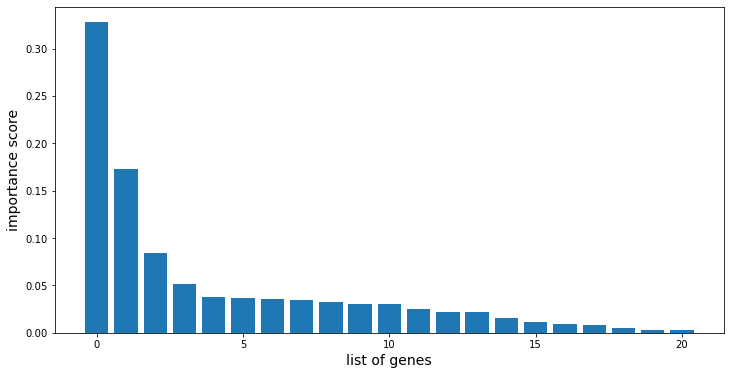

In [197]:

model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], sorted(importance, reverse = True))
plt.ylabel('importance score', fontsize=14)
plt.xlabel('list of genes', fontsize=14)
plt.show()

### Patient Network Community Detection (unweighted, non-overlapping)
Noticed large number of isolated nodes.

In [51]:
# com = algorithms.louvain(G)
print('Num of isolated nodes', len(list(nx.isolates(G))) )
G.remove_nodes_from(list(nx.isolates(G)))

com = algorithms.greedy_modularity(G)
# com = algorithms.agdl(G,number_communities=3, kc=4)
com.to_node_community_map()

Num of isolated nodes 74


defaultdict(list,
            {5: [0],
             9: [0],
             15: [0],
             17: [0],
             18: [0],
             22: [0],
             23: [0],
             26: [0],
             29: [0],
             30: [0],
             31: [0],
             34: [0],
             35: [0],
             36: [0],
             44: [0],
             50: [0],
             51: [0],
             64: [0],
             66: [0],
             67: [0],
             69: [0],
             70: [0],
             71: [0],
             74: [0],
             84: [0],
             85: [0],
             87: [0],
             93: [0],
             102: [0],
             119: [0],
             120: [0],
             125: [0],
             126: [0],
             127: [0],
             128: [0],
             129: [0],
             130: [0],
             131: [0],
             132: [0],
             133: [0],
             134: [0],
             136: [0],
             137: [0],
             139: [0],


In [52]:
clusters = com.to_node_community_map()

com_list = np.array(list(clusters.values())).flatten()
com_num = max(com_list)+1
node_list = list(clusters.keys())
print(com_num)
LN_p = [0]*com_num
Bone_p = [0]*com_num
Liver_p = [0]*com_num

for i in range(len(com_list)):
    node_No = node_list[i]
    com_NO = com_list[i]
#     print(com_NO)
    if node_No <117:
        LN_p[com_NO]+=1
    elif node_No >= 117 and node_No <191:
        Bone_p[com_NO]+=1
    else:
        Liver_p[com_NO]+=1
        
print(sum(LN_p),sum(Bone_p),sum(Liver_p))
patient_com_df = pd.DataFrame()
patient_com_df['LN'] = LN_p
patient_com_df['Bone'] = Bone_p
patient_com_df['Liver'] = Liver_p
patient_com_df

14
82 65 10


,LN,Bone,Liver
0,29,48,3
1,34,4,3
2,9,0,0
3,0,5,0
4,3,0,0
5,0,3,0
6,2,0,0
7,2,0,0
8,2,0,0
9,1,1,0


FitnessResult(min=None, max=None, score=0.06607899773476758, std=None)


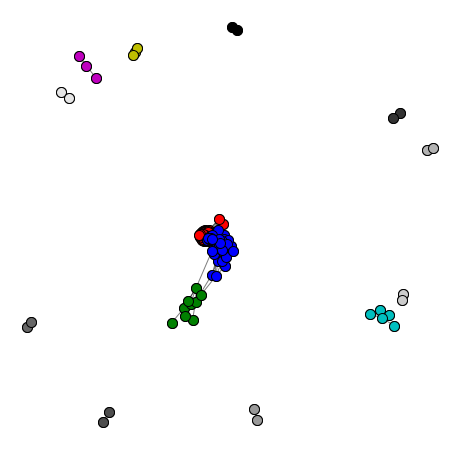

In [53]:
print(com.newman_girvan_modularity())
# com.z_modularity()
viz.plot_network_clusters(G, com, node_size = 100)